<a href="https://colab.research.google.com/github/areyesan/Keras_tools/blob/main/RandAugment_for_Image_Classification_for_Improved_Robustness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install imgaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from imgaug import augmenters as iaa
import imgaug as ia

tfds.disable_progress_bar()
tf.random.set_seed(42)
ia.seed(42)


In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print(f"Total training examples: {len(x_train)}")
print(f"Total test examples: {len(x_test)}")

170508288/170498071 [==============================] - 2s 0us/step
Total training examples: 50000
Total test examples: 10000


In [ ]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 128
EPOCHS = 50
IMAGE_SIZE = 72

In [ ]:
rand_aug = iaa.RandAugment(n=3, m=7)


def augment(images):
    # Input to `augment()` is a TensorFlow tensor which
    # is not supported by `imgaug`. This is why we first
    # convert it to its `numpy` variant.
    images = tf.cast(images, tf.uint8)
    return rand_aug(images=images.numpy())

In [ ]:
train_ds_rand = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
    .map(
        lambda x, y: (tf.image.resize(x, (IMAGE_SIZE, IMAGE_SIZE)), y),
        num_parallel_calls=AUTO,
    )
    .map(
        lambda x, y: (tf.py_function(augment, [x], [tf.float32])[0], y),
        num_parallel_calls=AUTO,
    )
    .prefetch(AUTO)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .batch(BATCH_SIZE)
    .map(
        lambda x, y: (tf.image.resize(x, (IMAGE_SIZE, IMAGE_SIZE)), y),
        num_parallel_calls=AUTO,
    )
    .prefetch(AUTO)
)

In [ ]:
simple_aug = tf.keras.Sequential(
    [
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ]
)

# Now, map the augmentation pipeline to our training dataset
train_ds_simple = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
    .map(lambda x, y: (simple_aug(x), y), num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

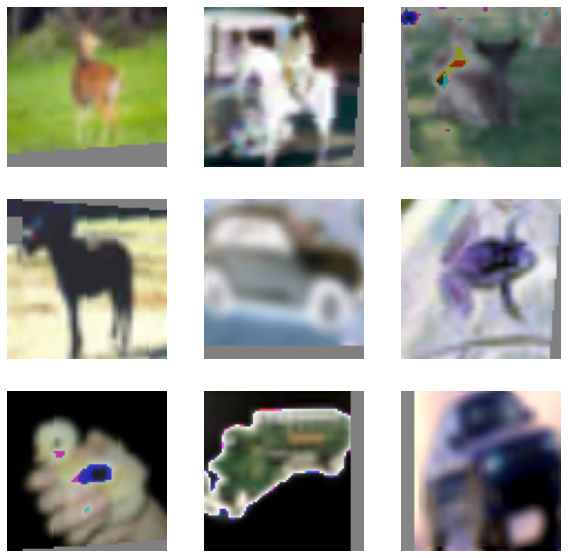

In [ ]:
sample_images, _ = next(iter(train_ds_rand))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("int"))
    plt.axis("off")

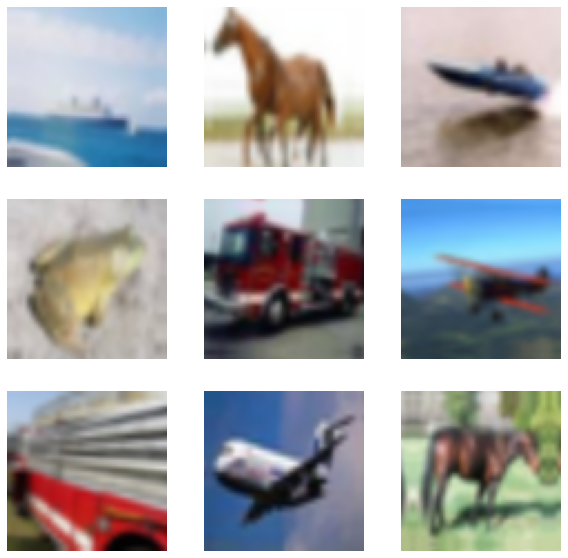

In [ ]:
sample_images, _ = next(iter(train_ds_simple))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("int"))
    plt.axis("off")

In [ ]:
def get_training_model():
    resnet50_v2 = tf.keras.applications.ResNet50V2(
        weights=None,
        include_top=True,
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
        classes=10,
    )
    model = tf.keras.Sequential(
        [
            layers.Input((IMAGE_SIZE, IMAGE_SIZE, 3)),
            layers.Rescaling(scale=1.0 / 127.5, offset=-1),
            resnet50_v2,
        ]
    )
    return model



In [ ]:
print(get_training_model().summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 72, 72, 3)         0         
                                                                 
 resnet50v2 (Functional)     (None, 10)                23585290  
                                                                 
Total params: 23,585,290
Trainable params: 23,539,850
Non-trainable params: 45,440
_________________________________________________________________
None


In [ ]:
initial_model = get_training_model()
initial_model.save_weights("initial_weights.h5")

In [ ]:
rand_aug_model = get_training_model()
rand_aug_model.load_weights("initial_weights.h5")
rand_aug_model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)
rand_aug_model.fit(train_ds_rand, validation_data=test_ds, epochs=EPOCHS)
_, test_acc = rand_aug_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/50
391/391 [==============================] - 108s 262ms/step - loss: 1.8267 - accuracy: 0.3496 - val_loss: 5.7450 - val_accuracy: 0.2194
Epoch 2/50
391/391 [==============================] - 101s 258ms/step - loss: 1.3918 - accuracy: 0.5067 - val_loss: 44.3170 - val_accuracy: 0.1877
Epoch 3/50
391/391 [==============================] - 101s 258ms/step - loss: 1.1754 - accuracy: 0.5852 - val_loss: 0.9660 - val_accuracy: 0.6628
Epoch 4/50
391/391 [==============================] - 102s 261ms/step - loss: 1.0220 - accuracy: 0.6412 - val_loss: 1.7206 - val_accuracy: 0.5721
Epoch 5/50
391/391 [==============================] - 101s 257ms/step - loss: 0.9213 - accuracy: 0.6807 - val_loss: 2.0007 - val_accuracy: 0.6223
Epoch 6/50
391/391 [==============================] - 103s 261ms/step - loss: 0.8427 - accuracy: 0.7088 - val_loss: 0.7811 - val_accuracy: 0.7369
Epoch 7/50
391/391 [==============================] - 103s 264ms/step - loss: 0.7799 - accuracy: 0.7302 - val_loss: 0.7274 

In [ ]:
simple_aug_model = get_training_model()
simple_aug_model.load_weights("initial_weights.h5")
simple_aug_model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)
simple_aug_model.fit(train_ds_simple, validation_data=test_ds, epochs=EPOCHS)
_, test_acc = simple_aug_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/50
391/391 [==============================] - 82s 198ms/step - loss: 1.5226 - accuracy: 0.4565 - val_loss: 2.9557 - val_accuracy: 0.3860
Epoch 2/50
391/391 [==============================] - 77s 196ms/step - loss: 1.1120 - accuracy: 0.6051 - val_loss: 1.5175 - val_accuracy: 0.5320
Epoch 3/50
391/391 [==============================] - 77s 196ms/step - loss: 0.9208 - accuracy: 0.6762 - val_loss: 1.1138 - val_accuracy: 0.6356
Epoch 4/50
391/391 [==============================] - 77s 197ms/step - loss: 0.7791 - accuracy: 0.7278 - val_loss: 0.7264 - val_accuracy: 0.7533
Epoch 5/50
391/391 [==============================] - 77s 196ms/step - loss: 0.6796 - accuracy: 0.7635 - val_loss: 1.0858 - val_accuracy: 0.6761
Epoch 6/50
391/391 [==============================] - 77s 196ms/step - loss: 0.6036 - accuracy: 0.7918 - val_loss: 0.8671 - val_accuracy: 0.7158
Epoch 7/50
391/391 [==============================] - 77s 196ms/step - loss: 0.5471 - accuracy: 0.8109 - val_loss: 0.6574 - val_ac

In [ ]:
# Load and prepare the CIFAR-10-C dataset
# (If it's not already downloaded, it takes ~10 minutes of time to download)
cifar_10_c = tfds.load("cifar10_corrupted/saturate_5", split="test", as_supervised=True)
cifar_10_c = cifar_10_c.batch(BATCH_SIZE).map(
    lambda x, y: (tf.image.resize(x, (IMAGE_SIZE, IMAGE_SIZE)), y),
    num_parallel_calls=AUTO,
)



Dataset cifar10_corrupted downloaded and prepared to ~/tensorflow_datasets/cifar10_corrupted/saturate_5/1.0.0. Subsequent calls will reuse this data.
Accuracy with RandAugment on CIFAR-10-C (saturate_5): 35.13%
Accuracy with simple_aug on CIFAR-10-C (saturate_5): 36.89%


In [ ]:
# Evaluate `rand_aug_model`
_, test_acc = rand_aug_model.evaluate(cifar_10_c, verbose=0)
print(
    "Accuracy with RandAugment on CIFAR-10-C (saturate_5): {:.2f}%".format(
        test_acc * 100
    )
)

# Evaluate `simple_aug_model`
_, test_acc = simple_aug_model.evaluate(cifar_10_c, verbose=0)
print(
    "Accuracy with simple_aug on CIFAR-10-C (saturate_5): {:.2f}%".format(
        test_acc * 100
    )
)

Accuracy with RandAugment on CIFAR-10-C (saturate_5): 81.20%
Accuracy with simple_aug on CIFAR-10-C (saturate_5): 72.96%
